# The Statistics of Ngau-ngau, a Chinese Gambling Card Game

## Hands

In this notebook, the standard 52-card deck will be notated in the format of "suit-numeral".

The four suits are namely Club, Diamond, Heart, and Spade.

The notation of 52 cards in the deck is exhausted as follows:

```
C1 C2 C3 ... C10 CJ CQ CK

D1 D2 D3 ... D10 DJ DQ DK

H1 H2 H3 ... H10 HJ HQ HK

S1 S2 S3 ... S10 SJ SQ SK
```


## Create the deck

Define a function which generates a standard 52-card deck according to the above notation.

In [3]:
# creating the deck
def create_deck():
    suits = ['C', 'D', 'H', 'S']
    numericals = [str(x) for x in range(1,11)] + ['J','Q','K']
    return [s+n for s in suits for n in numericals]
    
deck = create_deck()

## Drawing a random card

A function to randomly draw n cards from the deck.

In [4]:
import random

# random draw 5 cards
def get_random_card(seed):
    random.seed(seed)
    return random.sample(deck, 5)

seed = 0
cards = get_random_card(seed)
print(cards)

['DQ', 'S10', 'H1', 'C3', 'D4']


## Hand arrangement algorithm

The function `best_arrangement` takes in 5 cards and arrange the best hand possible.

In [5]:
# takes a list of cards and return a list of numerical values
def get_numeric(cards):
    tot = [int(c[-1]) if c[-1] not in ['J','Q','K'] else 0 for c in cards]
    return sum(tot) % 10


"""
function to arrange the cards for game-enable
brute force solution
"""
# returns formation in the format of array [[(3 cards),(2 cards)]]
def arrange(cards):
    # look for formation of 0 
    result = []
    for ipos, i in enumerate(cards):
        for jpos, j in enumerate(cards):
            if ipos == jpos:
                continue
            n = cards[:]
            if ipos < jpos:
                n.pop(jpos)
                n.pop(ipos)
            if ipos > jpos:
                n.pop(ipos)
                n.pop(jpos)
            if get_numeric(n) == 0 or len(set([c[-1] for c in n])) == 1:
                result.append(n)
    if result:
        # to remove duplicates
        arrangement_list = set(tuple(k) for k in result)
        return [[arr,tuple(set(cards)-set(arr))] for arr in arrangement_list]
    else:
        return result


def best_arrangement(cards):
    form = arrange(cards)
    # game-enabled scenario
    best_arr = None
    best_arr_cards = None
    # the below checks hand from smallest to greatest
    if form:
        digits = [get_numeric(f[-1]) for f in form]
        best_arr = f'ngau-{max(digits)}' if all([d != 0 for d in digits]) else 'ngau-ngau'
        # check for ngau-pair
        for f in form:
            top = f[-1] # tuple of two cards
            if top[0][-1] == top[1][-1]:
                best_arr = 'ngau-pair'
                break
    # not game-enabled scenario
    else:
        pass
    
    # all-big and all-small
    cards_numeric = [str(c[-1]) for c in cards]
    all_big = ['0','J','Q','K']
    all_small = ['1','2','3','4']
    if all([n in all_small for n in cards_numeric]):
        best_arr = 'all-small'
    if all([n in all_big for n in cards_numeric]):
        best_arr = 'all-big'
    if best_arr is None:
        best_arr = 'no-game'
    return best_arr

In [6]:
# example
cards = ['H2','D2','C2','C7','H7']
best_arr = best_arrangement(cards)
print(f'Cards are {cards}')
print(f'Best arrangement is {best_arr}')

Cards are ['H2', 'D2', 'C2', 'C7', 'H7']
Best arrangement is ngau-pair


In [7]:
# random draw card for many times
seeds = range(10,11)
for seed in seeds:
    cards = get_random_card(seed)
    hand_arrangement = best_arrangement(cards)
print(hand_arrangement)

ngau-1


## Hand Probabilities

The following two blocks does the same thing, but the latter one computes faster with parallel computing implemented.

In [15]:
import itertools
from collections import Counter
from tqdm import tqdm

hand = []
# exhaust all 2598960 (52C5) combinations
for c in tqdm(itertools.combinations(deck, 5)):
    c = list(c)
    hand.append((c,best_arrangement(c)))

hand_count = Counter([h[-1] for h in hand])
hand_percentage = {k: f'{round(v/len(hand)*100,2)}%' for k, v in hand_count.items()}

print(f'Number of all possible hands: {len(hand)}')
print(f'Possible number of combinations of each hand: {hand_count}')
print(f'Percentage of getting hand: {hand_percentage}')

2598960it [02:16, 19108.75it/s]
Number of all possible hands: 2598960
Possible number of combinations of each hand: Counter({'no-game': 841776, 'ngau-5': 179488, 'ngau-9': 174588, 'ngau-7': 174200, 'ngau-1': 173116, 'ngau-3': 172708, 'ngau-8': 147076, 'ngau-6': 146496, 'ngau-2': 145732, 'ngau-4': 145660, 'ngau-pair': 145480, 'ngau-ngau': 143904, 'all-small': 4368, 'all-big': 4368})
Percentage of getting hand: {'ngau-5': '6.91%', 'ngau-6': '5.64%', 'ngau-7': '6.7%', 'no-game': '32.39%', 'all-small': '0.17%', 'ngau-8': '5.66%', 'ngau-9': '6.72%', 'ngau-ngau': '5.54%', 'ngau-1': '6.66%', 'ngau-pair': '5.6%', 'ngau-3': '6.65%', 'ngau-4': '5.6%', 'ngau-2': '5.61%', 'all-big': '0.17%'}


In [6]:
# parallelized implementation
"""
Reference of parallelization using mp
https://www.machinelearningplus.com/python/parallel-processing-python/
"""
import itertools
from collections import Counter
from tqdm import tqdm
import multiprocessing as mp


hand = []
for c in tqdm(itertools.combinations(deck, 5)):
    c = list(c)
    hand.append(c)

# parallelization
pool = mp.Pool(mp.cpu_count())

hand_results = []
hand_results = pool.starmap_async(best_arrangement, [[h] for h in tqdm(hand)]).get()

pool.close()

print('Counting results...')

hand_count = Counter(hand_results)
hand_percentage = {k: f'{round(v/len(hand_results)*100,2)}%' for k, v in hand_count.items()}

print(f'Number of all possible hands: {len(hand_results)}')
print(f'Possible number of combinations of each hand: {hand_count}')
print(f'Percentage of getting hand: {hand_percentage}')


2598960it [00:02, 1062230.82it/s]
100%|██████████| 2598960/2598960 [00:01<00:00, 1313072.95it/s]
Counting results...
Number of all possible hands: 2598960
Possible number of combinations of each hand: Counter({'no-game': 841776, 'ngau-5': 179488, 'ngau-9': 174588, 'ngau-7': 174200, 'ngau-1': 173116, 'ngau-3': 172708, 'ngau-8': 147076, 'ngau-6': 146496, 'ngau-2': 145732, 'ngau-4': 145660, 'ngau-pair': 145480, 'ngau-ngau': 143904, 'all-small': 4368, 'all-big': 4368})
Percentage of getting hand: {'ngau-5': '6.91%', 'ngau-6': '5.64%', 'ngau-7': '6.7%', 'no-game': '32.39%', 'all-small': '0.17%', 'ngau-8': '5.66%', 'ngau-9': '6.72%', 'ngau-ngau': '5.54%', 'ngau-1': '6.66%', 'ngau-pair': '5.6%', 'ngau-3': '6.65%', 'ngau-4': '5.6%', 'ngau-2': '5.61%', 'all-big': '0.17%'}


Visualise the results in a pie chart.

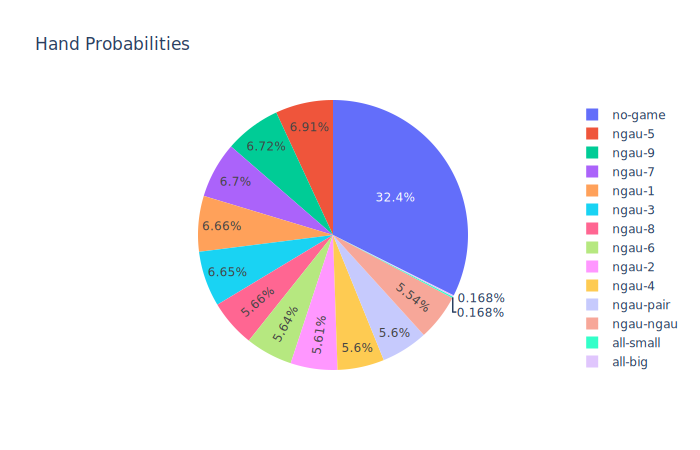

In [12]:
import plotly.express as px
import pandas as pd

# plot the result
fig = px.pie(pd.DataFrame({'index': [k for k in hand_count.keys()], 'prob': [v for v in hand_count.values()]}), names='index', values='prob', title='Hand Probabilities')
fig.show(renderer="svg")

## Hand rankings

The function `compare` takes two set of hands and compare their ranking, then return the payoff for each player.

In [8]:
## Comparison of two different hands

# setting up comparison dict by assigning explicit score to according to hand value
win_hierarchy = {'all-big': 13, 'all-small': 12, 'ngau-pair': 11, 'ngau-ngau': 10, 'no-game': 0} 
for x in range(1,10):
    win_hierarchy[f'ngau-{x}'] = x

win_payout = {'all-big': 5, 'all-small': 5, 'ngau-pair': 5, 'ngau-ngau': 4, 'ngau-9': 3, 'ngau-8': 2, 'ngau-7': 2, 'no-game': 1}
for x in range(1,7):
    win_payout[f'ngau-{x}'] = 1

card_dict = {'J':11, 'Q':12, 'K': 13}
for x in range(1,11):
    card_dict[str(x)] = x


# return winner for a list of high cards
def compare_sorted_list(a, b):
    if a and b:
        if a[0] > b[0]:
            return 0
        if a[0] < b[0]:
            return 1
        if a[0] == b[0]:
            return compare_sorted_list(a[1:], b[1:])
    else:
        return None


# comparison under no-game tie scenario
# return winner_idx
def compare_five_cards(h1, h2):
    winner_idx = None

    # check for number of pairs in the 5 cards
    h1_n = sorted([card_dict[h[1:]] for h in h1], reverse=True)
    h1_pairs = sorted([k for k, v in Counter(h1_n).items() if v > 1], reverse=True)

    h2_n = sorted([card_dict[h[1:]] for h in h2], reverse=True)
    h2_pairs = sorted([k for k, v in Counter(h2_n).items() if v > 1], reverse=True)

    if len(h1_pairs) > len(h2_pairs):
        winner_idx = 0
    elif len(h1_pairs) < len(h2_pairs):
        winner_idx = 1
    elif h1_pairs: # when len(h1_pairs) == len(h2_pairs) != 0
        winner_idx = compare_sorted_list(h1_pairs, h2_pairs)
    else: # when len(h1_pairs) == len(h2_pairs) == 0
        winner_idx = compare_sorted_list(h1_n, h2_n)
    
    return winner_idx


def payout_handler(winner_idx, winner_hand):
    # no payout for tie
    if winner_idx is None:
        return (0,0)
    else:
        mult = win_payout[winner_hand]
        payout = (mult, mult * -1) if winner_idx==0 else (mult * -1, mult)
        return payout


# input of h1, h2 should be two lists
# winner_idx = 0 means h1 wins; h2 if winner_idx = 1
# return a tuple representing result of pnl
def comparison(h1, h2):
    h1_hand = best_arrangement(h1)
    h2_hand = best_arrangement(h2)
    h1_pt = win_hierarchy[h1_hand]
    h2_pt = win_hierarchy[h2_hand]

    if h1_pt > h2_pt:
        winner_idx, winner_hand = 0, h1_hand
    elif h1_pt < h2_pt:
        winner_idx, winner_hand = 1, h2_hand
    else:
        # tie cases when both players got "no-game"
        if h1_pt == 0:
            winner_idx, winner_hand = compare_five_cards(h1, h2), 'no-game'
        else:
            winner_idx, winner_hand = None, h1_hand
    return payout_handler(winner_idx, winner_hand)


# Demonstration
for _ in range(3):
    h1 = get_random_card(random.random())
    h2 = get_random_card(random.random())
    print(f'h1 cards are {h1}')
    print(f'h2 cards are {h2}')
    print(comparison(h1, h2))
    print('-----------------')

h1 cards are ['S8', 'HJ', 'S7', 'H9', 'C4']
h2 cards are ['H3', 'C3', 'S9', 'S4', 'D2']
(2, -2)
-----------------
h1 cards are ['CJ', 'D6', 'D1', 'D8', 'C3']
h2 cards are ['D3', 'DQ', 'D6', 'DJ', 'H5']
(2, -2)
-----------------
h1 cards are ['H7', 'H2', 'H3', 'H9', 'C1']
h2 cards are ['D4', 'S3', 'HJ', 'H4', 'S1']
(1, -1)
-----------------


## Theoretical expectation value of banker

We try to exhaust all possible hand competition of two players. However, this is not computationally feasible as the number of combination escalates to 52C10 just for two players.

In [ ]:
# parallelized implementation
# not enough computational power to run
"""
Reference of parallelization using mp
https://www.machinelearningplus.com/python/parallel-processing-python/
"""
import multiprocessing as mp

all_hands_two_players = [(h,g) for h in hand for g in hand if h!=g]
print(len(all_hands_two_players))

def theoretical_comparison(h,g):
    return comparison(h,g)[0]

# parallelization
pool = mp.Pool(mp.cpu_count())

all_banker_payoff = []
all_banker_payoff = pool.starmap_async(theoretical_comparison, [(hhs[0],hhs[1]) for hhs in tqdm(all_hands_two_players)]).get()

pool.close()

print(f'Banker\'s theoretical EV is: {sum(all_payoff)/len(all_payoff)}')

## Visualize payoff history in one session

The following code simulates the playing of ngau-ngau for n players and r rounds for 1 session.
The graph shows the trend of bankroll of this random session.

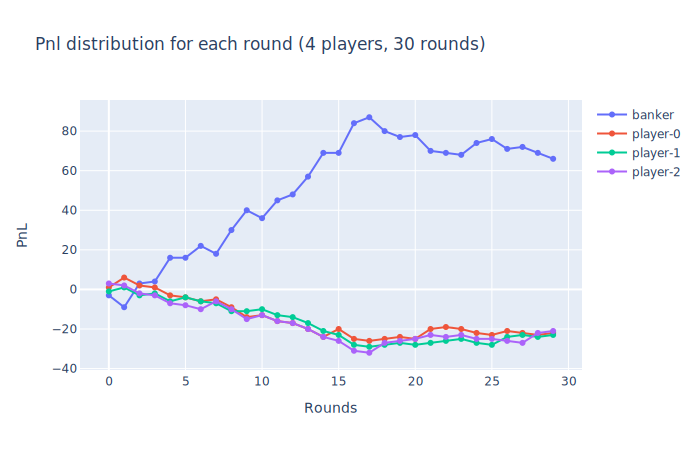

In [18]:
from tqdm import tqdm
from collections import Counter

# simulation of playing between 1 chosen banker and n players
player_num = 3
rounds = 30
sessions = 1


def get_random_card_for_players(player_num):
    return random.sample(deck, (player_num+1)*5)


def initialize_game(player_num):
    pnl = {'banker': []}
    for n in range(player_num):
        pnl[f'player-{n}'] = []
    return pnl


def one_session(rounds, player_num):
    pnl = initialize_game(player_num)
    for _ in range(rounds):
        hands_dict = {}
        # get all cards at one time as there are correlations between hands (draw from same deck)
        return_cards = get_random_card_for_players(player_num)
        for idx, k in enumerate(pnl.keys()):
            hands_dict[k] = return_cards[idx*5:(idx+1)*5]
        # banker compare with each player
        banker_payoff = 0
        for k, v in hands_dict.items():
            if k != 'banker':
                payoff = comparison(hands_dict['banker'], v)
                banker_payoff += payoff[0]
                pnl[k].append(payoff[1])
        pnl['banker'].append(banker_payoff)
    return pnl

result = one_session(rounds, player_num)


import plotly.graph_objects as go

players_list = ['banker', 'player-0', 'player-1', 'player-2']
result = pd.DataFrame(result, index=None)

fig = go.Figure()
for p in players_list:
    fig.add_trace(go.Scatter(x=result.index, y=result[p].cumsum(), mode='lines+markers', name=p))
fig.update_layout(title='Pnl distribution for each round (4 players, 30 rounds)',
                   xaxis_title='Rounds',
                   yaxis_title='PnL')
fig.show('svg')

## Monte Carlo simulation

The following code simulates the playing of ngau-ngau for $n$ players, $r$ rounds, and interate over $s$ sessoins.
The function `play_sessions` returns only the final profit and loss (PnL), but not the intermediate payoffs.

In [19]:
from tqdm import tqdm
from collections import Counter

# simulation of playing between 1 chosen banker and n players
player_num = 4
rounds = 30
sessions = 2000


def get_random_card_for_players(player_num):
    return random.sample(deck, (player_num+1)*5)


def initialize_game(player_num):
    pnl = {'banker': []}
    for n in range(player_num):
        pnl[f'player-{n}'] = []
    return pnl


def one_session(rounds, player_num):
    pnl = initialize_game(player_num)
    for _ in range(rounds):
        hands_dict = {}
        # get all cards at one time as there are correlations between hands (draw from same deck)
        return_cards = get_random_card_for_players(player_num)
        for idx, k in enumerate(pnl.keys()):
            hands_dict[k] = return_cards[idx*5:(idx+1)*5]
        # banker compare with each player
        banker_payoff = 0
        for k, v in hands_dict.items():
            if k != 'banker':
                payoff = comparison(hands_dict['banker'], v)
                banker_payoff += payoff[0]
                pnl[k].append(payoff[1])
        pnl['banker'].append(banker_payoff)
    return {k: sum(v) for k,v in pnl.items()}


def play_sessions(rounds, player_num, sessions):
    pnl_list = []
    for _ in tqdm(range(sessions), desc=f'r={rounds}, n={player_num}'):
        pnl = one_session(rounds, player_num)
        pnl_list.append(pnl)
    return pnl_list


result = play_sessions(rounds, player_num, sessions)

r=30, n=4: 100%|██████████| 2000/2000 [00:25<00:00, 79.54it/s]


In [22]:
import pandas as pd

# analysis
dflist = []
for y in result:
    for k, v in y.items():
        dflist.append({'pnl':v, 'player':k})
# df = pd.DataFrame(result)
df = pd.DataFrame(dflist)
df.head(10)

,pnl,player
0,29,banker
1,-16,player-0
2,7,player-1
3,-10,player-2
4,-10,player-3
5,-34,banker
6,12,player-0
7,24,player-1
8,-11,player-2
9,9,player-3


One dot in the following graph represents the final PnL of the player. There are totally 2000 sessions `(s = 2000)`.

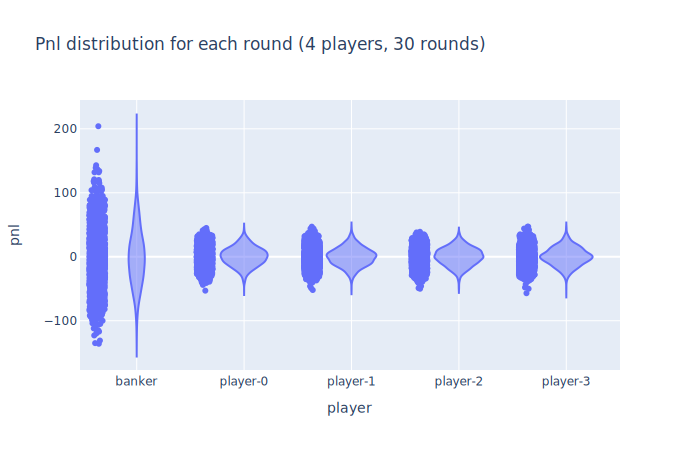

In [24]:
import plotly.express as px

fig = px.violin(df, x='player', y='pnl', points='all', title='Pnl distribution for each round (4 players, 30 rounds)')
fig.show('svg')

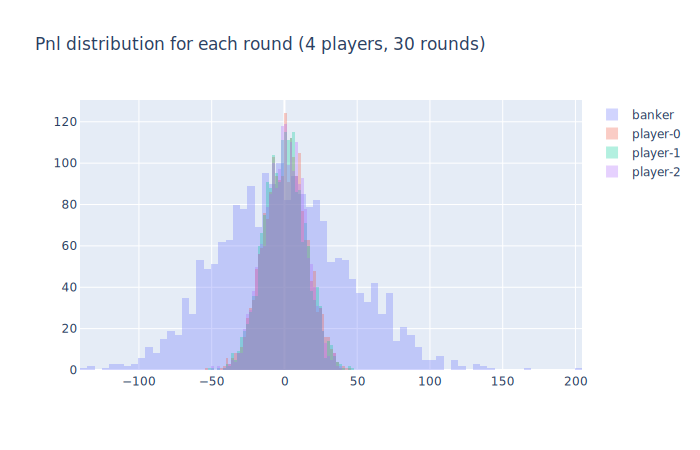

In [25]:
import plotly.graph_objects as go

fig = go.Figure()
for x in ['banker', 'player-0', 'player-1', 'player-2']:
    fig.add_trace(go.Histogram(x=df[df.player==x]['pnl'], name=x))
fig.update_layout(barmode='overlay', title='Pnl distribution for the sessions (4 players, 30 rounds)')
fig.update_traces(opacity=0.3)
fig.show('svg')

The function `stat_of` returns the statistical moments and figures (mean, variance, skewness, kurtosis, 0-100 quantiles) from the previous 2000 sessions

In [22]:
from scipy.stats import kurtosis, skew
from scipy.stats.mstats import mquantiles
import statistics
import numpy as np


def stat_of(df, player):
    data = df[df.player==player]['pnl']
    mean = statistics.mean(data)
    var =  statistics.variance(data)
    sd = statistics.stdev(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    qts = list(mquantiles(data, prob=np.linspace(0, 1, num=11)))
    return {'mean': mean, 'var': var, 'sd': sd, 'skewness': skewness, 'kurt': kurt, 'quantiles': qts}


def session_stat(session_result):
    # make analysis df
    dflist = []
    list_of_players = session_result[0].keys()

    for y in session_result:
        for k, v in y.items():
            dflist.append({'pnl':v, 'player':k})
    session_df = pd.DataFrame(dflist)
    
    session_stat_dict = {}
    for p in list_of_players:
        session_stat_dict[p] = stat_of(session_df, p)
    return session_stat_dict

# demo
tmp_session_result = play_sessions(5, 4, 20)
session_stat(tmp_session_result)

r=5, n=4: 100%|██████████| 20/20 [00:00<00:00, 397.96it/s]


{'banker': {'mean': -0.45,
  'var': 153.31315789473683,
  'sd': 12.381969063712639,
  'skewness': 0.3070791781337764,
  'kurt': -1.0756964633356374,
  'quantiles': [-18.0,
   -15.0,
   -14.0,
   -9.54,
   -3.5199999999999996,
   -2.5,
   1.6000000000000068,
   6.540000000000003,
   12.239999999999995,
   18.159999999999997,
   22.0]},
 'player-0': {'mean': 0.35,
  'var': 10.660526315789474,
  'sd': 3.265046142980138,
  'skewness': 0.1543074567903067,
  'kurt': -0.8352653263582495,
  'quantiles': [-5.0,
   -4.0,
   -3.0,
   -1.5399999999999991,
   0.0,
   0.0,
   1.0,
   2.0,
   3.0,
   5.579999999999998,
   6.0]},
 'player-1': {'mean': 0.05,
  'var': 25.207894736842107,
  'sd': 5.020746432239146,
  'skewness': -0.8852488882181375,
  'kurt': 0.7517069306824506,
  'quantiles': [-13.0,
   -7.32,
   -2.5599999999999996,
   -1.0,
   -1.0,
   0.5,
   1.0,
   3.0,
   4.0,
   6.579999999999998,
   7.0]},
 'player-2': {'mean': -0.65,
  'var': 21.818421052631578,
  'sd': 4.67101927341684,
  'ske

## Parallelized implementation

The following code carries out a grid search (conduct Monte Carlo simulation for different values of $n$ and $r$), and returns the statistical moments for each combination of $(n,r)$ pairs.

In [26]:
"""
Reference of parallelization using mp
https://www.machinelearningplus.com/python/parallel-processing-python/
Async starmap is used
"""
import multiprocessing as mp
import json

# search for statistical result for change in parameters
def grid_search_once(n, r, sessions):
    tmp_session_result = play_sessions(r, n, sessions)
    return {str((n,r)): session_stat(tmp_session_result)}


def parallel_grid_search(player_num, rounds, sessions=1000):
    # parallelization
    param_list = [(n,r,sessions) for n in player_num for r in rounds]
    pool = mp.Pool(mp.cpu_count())

    sessions_results = []
    sessions_results = pool.starmap_async(grid_search_once, [(pl[0], pl[1], sessions) for pl in param_list]).get()

    pool.close()
    final_result = {}
    for d in sessions_results:
        final_result.update(d)
    return final_result

# player_num must be 2 or above; rounds must be >= 1
grid = parallel_grid_search(player_num=list(range(2,9)), rounds=list(range(20, 110, 10)))

# write to file
with open('./result.json', 'w+') as fp:
    json.dump(grid, fp)

r=90, n=8: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]


The following code has the same logic as the above one, but without parallelization. This might take forever to run for around $s > 2000$.

In [18]:
# unparalleled implementation; computationally slow so do not run

def grid_search(player_num, rounds, sessions=1000):
    grid = {}
    for n in player_num:
        for r in rounds:
            tmp_session_result = play_sessions(r, n, sessions)
            grid[(n,r)] = session_stat(tmp_session_result)
    return grid

# player_num must be 2 or above; rounds must be >= 1
grid_search(player_num=list(range(2,3)), rounds=list(range(20, 50, 10)))

## Visualisation of Banker's Statistical Moments

In [2]:
import json

with open('./result.json') as f:
    grid = json.load(f)

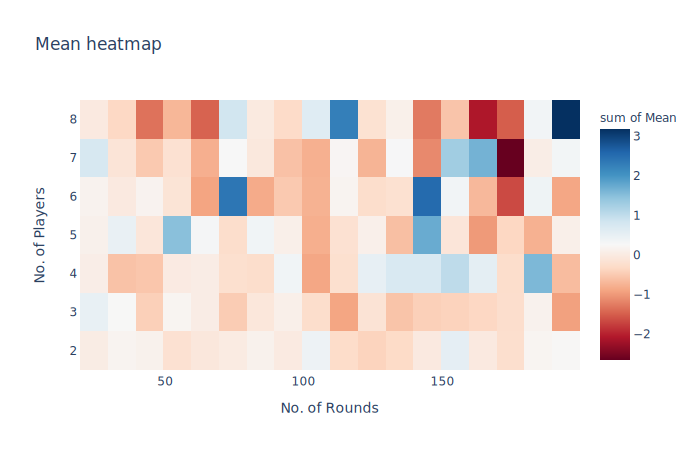

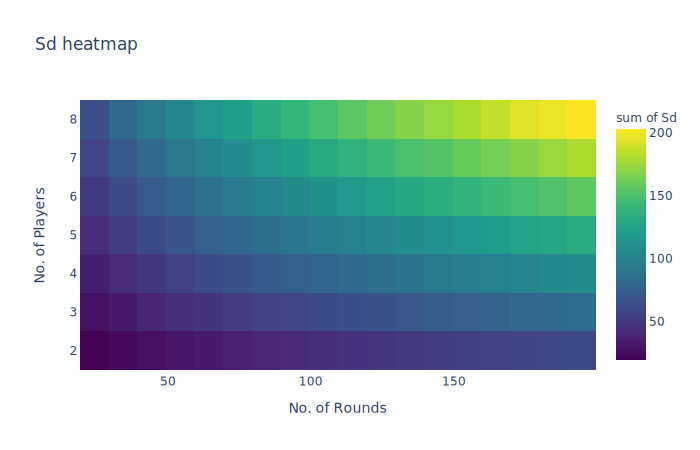

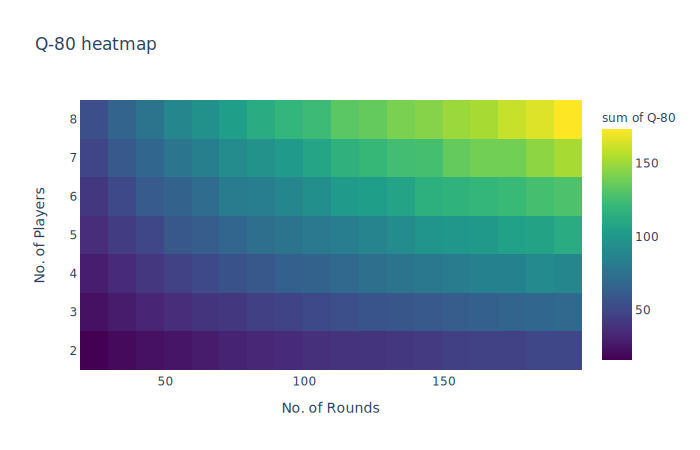

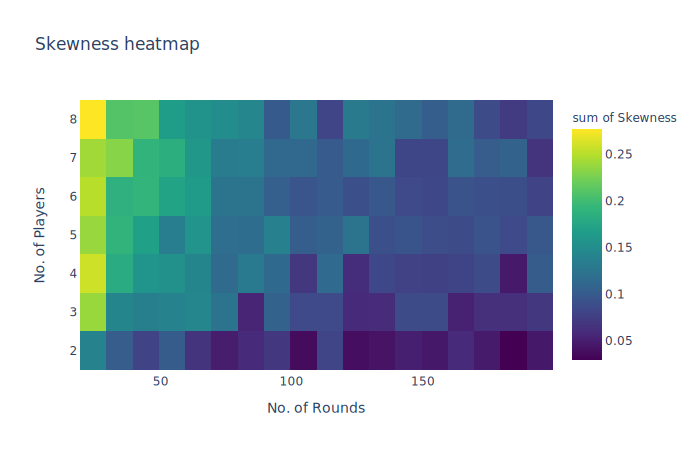

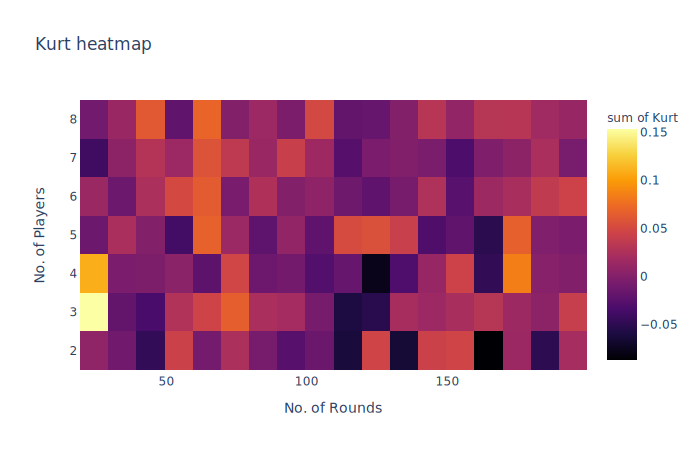

In [2]:
import plotly.express as px

moments = {'mean':'RdBU', 'sd':'Viridis', 'q-80': 'Viridis', 'skewness':'Viridis', 'kurt':'Inferno'}

for m, scale in moments.items():
    # dimensions
    dots_x = [eval(k)[1] for k,v in grid.items()]
    dots_y = [eval(k)[0] for k,v in grid.items()]
    if m == 'q-80':
        dots_color = [v['banker']['quantiles'][8] for v in grid.values()]
    else:
        dots_color = [v['banker'][m] for v in grid.values()]
    labels = {'x':'No. of Rounds', 'y':'No. of Players', 'z':f'{m.capitalize()}'}

    fig = px.density_heatmap(x=dots_x, y=dots_y, z=dots_color, nbinsx=20, nbinsy=8, color_continuous_scale=scale, title=f'{m.capitalize()} heatmap', labels=labels)
    fig.show('svg')

## Forecasting 90-th percentile

Regression of the value of 90-th percentile on $n$, $r$, and an identity variable `is_banker`

In [3]:
n = [eval(k)[0] for k,v in grid.items()]
r = [eval(k)[1] for k,v in grid.items()]

In [131]:
import pandas as pd


def grid_to_regression(grid):
    rename_dict = {0:'n', 1:'r', 2:'is_banker', 3:'y'}
    reg = []
    for k,v in grid.items():
        n, r = eval(k)[0], eval(k)[1]
        for p, q in v.items():
            is_banker = 1 if p == 'banker' else 0
            y = q['var']
            reg.append([n, r, is_banker, y])
    return pd.DataFrame(reg).drop_duplicates(keep='first').reset_index(drop=True).rename(columns=rename_dict)


regdf = grid_to_regression(grid)
regdf

,n,r,is_banker,y
0,2,20,1,375.487386
1,2,20,0,128.879429
2,2,20,0,130.432452
3,2,30,1,572.581303
4,2,30,0,197.313920
...,...,...,...,...
751,8,190,0,1242.671706
752,8,190,0,1239.265552
753,8,190,0,1221.858462
754,8,190,0,1240.754506


In [132]:
import plotly.express as px

fig = px.scatter_3d(regdf[(regdf.is_banker==0)], x='n', y='r', z='y', size_max=18,  opacity=0.5)
fig.show()

In [136]:
import statsmodels.api as sm

df = regdf[regdf.is_banker==0]
df['n_root'] = df['n'].apply(lambda x: x**0.5)
dep = df[['n','r']]
target = df[['y']]

model = sm.OLS(target, dep).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.130e+06
Date:                Sun, 30 Aug 2020   Prob (F-statistic):                        0.00
Time:                        03:35:35   Log-Likelihood:                         -2176.7
No. Observations:                 630   AIC:                                      4357.
Df Residuals:                     628   BIC:                                      4366.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
n             -0.0818      0.097     -0.844      0.399      -0.272       0.108
r              6.5353      0.005   1298.996      0.000       6.525       6.545
==============================================================================
Omnibus:                       24.860   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.119
Skew:                          -0.212   Prob(JB):                     7.94e-12
Kurtosis:                       4.329   Cond. No.                         37.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""